# **Regression Analysis for Predicting Success on College Exams**

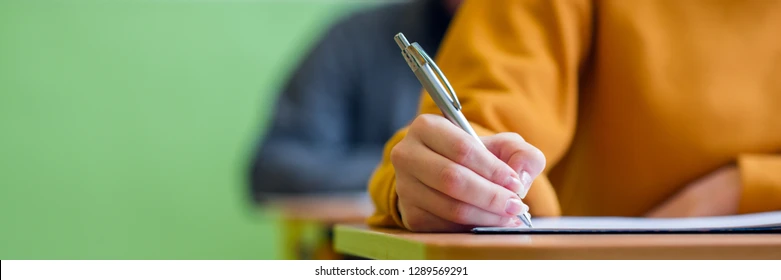

## **Business Understanding**


## **Data Understanding**




### **Collect Initial Data**

In [1]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns
import statsmodels.api as sm
from sklearn.preprocessing import OneHotEncoder, StandardScaler, PolynomialFeatures
from sklearn.datasets import make_regression
from sklearn.linear_model import LinearRegression, HuberRegressor, RANSACRegressor, TheilSenRegressor, Ridge
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV, RandomizedSearchCV
from sklearn.pipeline import Pipeline
import sklearn.metrics as metrics
from sklearn.metrics import confusion_matrix
from random import gauss
from mpl_toolkits.mplot3d import Axes3D
from scipy import stats as stats
import scipy.stats as ss
from sklearn.ensemble import RandomForestRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.svm import SVR
from sklearn.tree import plot_tree



%matplotlib inline

In [2]:
#Collect inititial data - Load data into analysis tool
data = pd.read_csv('https://raw.githubusercontent.com/josh-g-grimes/Regression-Analysis---College-Exam-Performance/main/StudentPerformanceFactors.csv')

### **Describe Data**

In [3]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6607 entries, 0 to 6606
Data columns (total 20 columns):
 #   Column                      Non-Null Count  Dtype 
---  ------                      --------------  ----- 
 0   Hours_Studied               6607 non-null   int64 
 1   Attendance                  6607 non-null   int64 
 2   Parental_Involvement        6607 non-null   object
 3   Access_to_Resources         6607 non-null   object
 4   Extracurricular_Activities  6607 non-null   object
 5   Sleep_Hours                 6607 non-null   int64 
 6   Previous_Scores             6607 non-null   int64 
 7   Motivation_Level            6607 non-null   object
 8   Internet_Access             6607 non-null   object
 9   Tutoring_Sessions           6607 non-null   int64 
 10  Family_Income               6607 non-null   object
 11  Teacher_Quality             6529 non-null   object
 12  School_Type                 6607 non-null   object
 13  Peer_Influence              6607 non-null   obje

In [4]:
data.isna().sum()

,0
Hours_Studied,0
Attendance,0
Parental_Involvement,0
Access_to_Resources,0
Extracurricular_Activities,0
Sleep_Hours,0
Previous_Scores,0
Motivation_Level,0
Internet_Access,0
Tutoring_Sessions,0


In [5]:
data = data.dropna()

In [6]:
#Separate columns into numerical and categorical data
categoricals = data.select_dtypes(include='object')
numericals = data.select_dtypes(exclude='object')

In [7]:
for col in numericals:
    print(data[col].describe())
    print()

count    6378.000000
mean       19.977109
std         5.985460
min         1.000000
25%        16.000000
50%        20.000000
75%        24.000000
max        44.000000
Name: Hours_Studied, dtype: float64

count    6378.000000
mean       80.020853
std        11.550723
min        60.000000
25%        70.000000
50%        80.000000
75%        90.000000
max       100.000000
Name: Attendance, dtype: float64

count    6378.000000
mean        7.034964
std         1.468033
min         4.000000
25%         6.000000
50%         7.000000
75%         8.000000
max        10.000000
Name: Sleep_Hours, dtype: float64

count    6378.000000
mean       75.066165
std        14.400389
min        50.000000
25%        63.000000
50%        75.000000
75%        88.000000
max       100.000000
Name: Previous_Scores, dtype: float64

count    6378.000000
mean        1.495296
std         1.233984
min         0.000000
25%         1.000000
50%         1.000000
75%         2.000000
max         8.000000
Name: Tutoring_

In [8]:
#Inspect the value counts for the categorical features
for col in categoricals.columns:
    print(categoricals[col].value_counts())
    print()

Parental_Involvement
Medium    3251
High      1836
Low       1291
Name: count, dtype: int64

Access_to_Resources
Medium    3204
High      1900
Low       1274
Name: count, dtype: int64

Extracurricular_Activities
Yes    3807
No     2571
Name: count, dtype: int64

Motivation_Level
Medium    3237
Low       1864
High      1277
Name: count, dtype: int64

Internet_Access
Yes    5893
No      485
Name: count, dtype: int64

Family_Income
Low       2582
Medium    2566
High      1230
Name: count, dtype: int64

Teacher_Quality
Medium    3826
High      1905
Low        647
Name: count, dtype: int64

School_Type
Public     4434
Private    1944
Name: count, dtype: int64

Peer_Influence
Positive    2553
Neutral     2495
Negative    1330
Name: count, dtype: int64

Learning_Disabilities
No     5710
Yes     668
Name: count, dtype: int64

Parental_Education_Level
High School     3159
College         1939
Postgraduate    1280
Name: count, dtype: int64

Distance_from_Home
Near        3801
Moderate    1941
Fa

### **Explore Data**

In [9]:
#Find the most correlated numerical value to the target variable
data.corr(numeric_only=True)["Exam_Score"].sort_values(ascending=False)

,Exam_Score
Exam_Score,1.000000
Attendance,0.580259
Hours_Studied,0.445104
Previous_Scores,0.174283
Tutoring_Sessions,0.156829
Physical_Activity,0.025148
Sleep_Hours,-0.017171


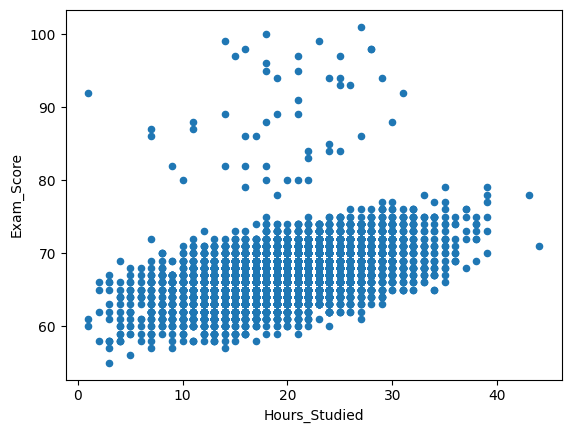

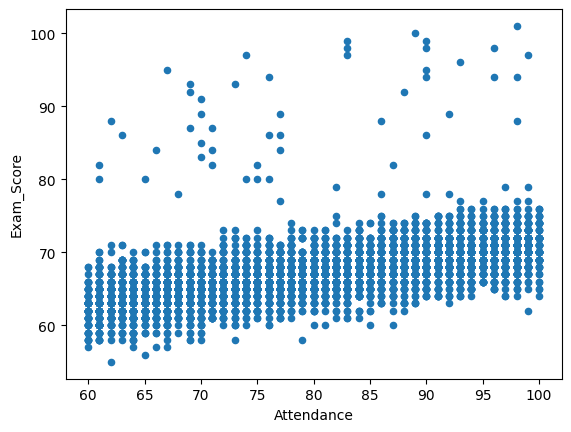

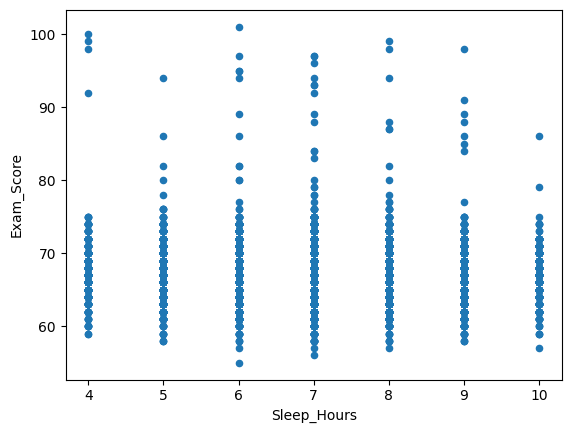

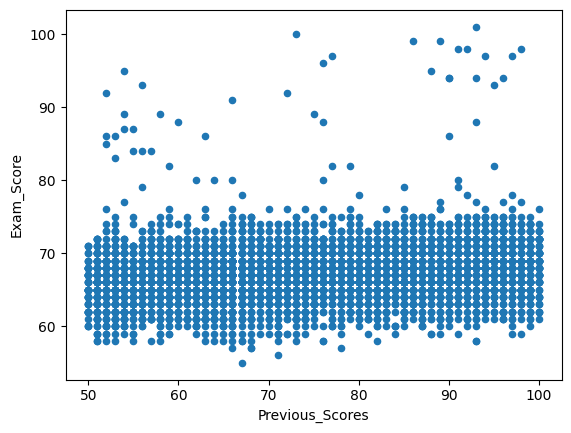

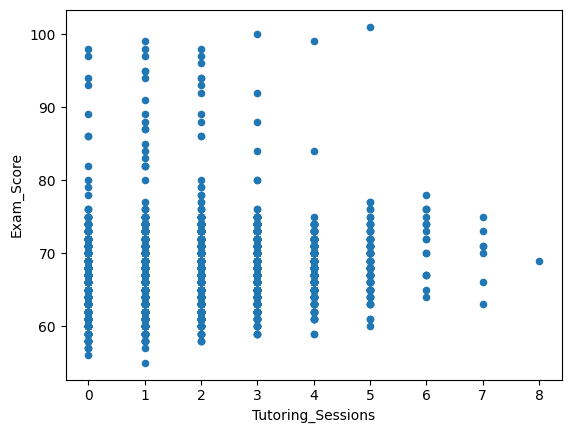

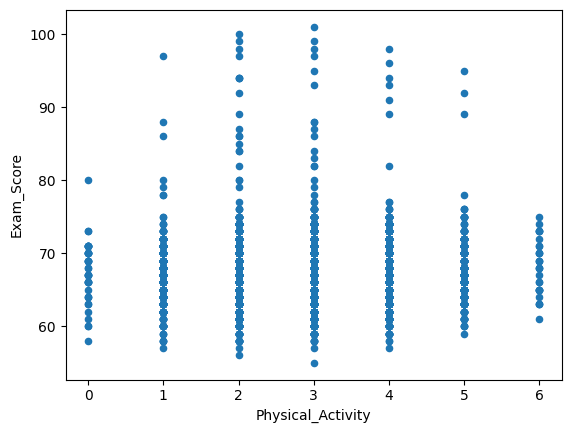

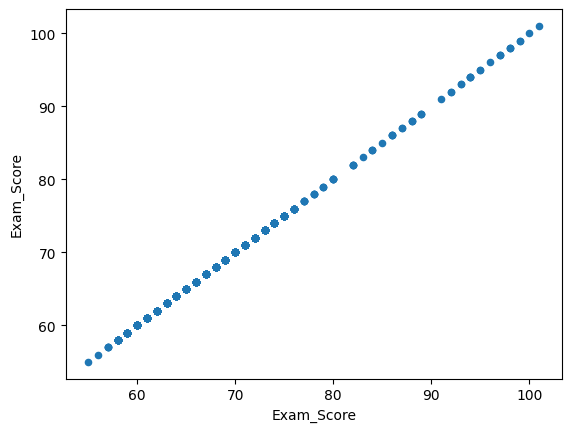

In [10]:
for col in data.corr(numeric_only=True).columns:
    data.plot.scatter(x=col, y='Exam_Score')

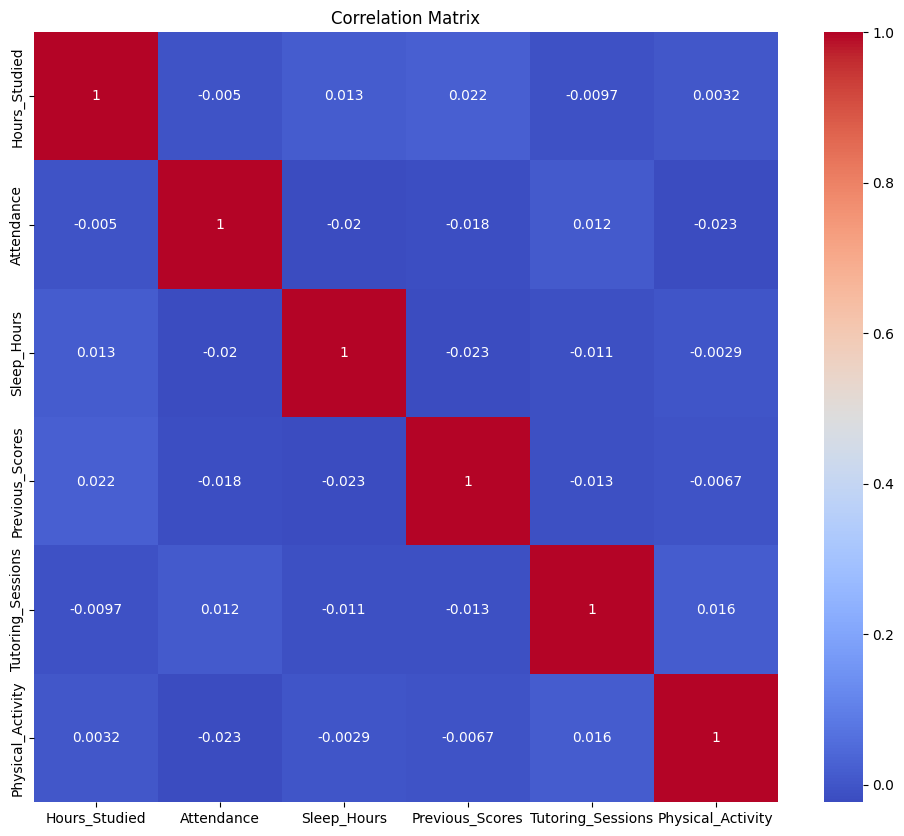

In [11]:
correlation_matrix = numericals.drop(columns='Exam_Score').corr()
plt.figure(figsize=(12, 10))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm')
plt.title('Correlation Matrix')
plt.show()

In [12]:
def cramers_v(x, y):
    confusion_matrix = pd.crosstab(x,y)
    chi2 = ss.chi2_contingency(confusion_matrix)[0]
    n = confusion_matrix.sum().sum()
    phi2 = chi2/n
    r,k = confusion_matrix.shape
    phi2corr = max(0, phi2-((k-1)*(r-1))/(n-1))
    rcorr = r-((r-1)**2)/(n-1)
    kcorr = k-((k-1)**2)/(n-1)
    return np.sqrt(phi2corr/min((kcorr-1),(rcorr-1)))

Source: [Stack Overflow](https://stackoverflow.com/questions/46498455/categorical-features-correlation/46498792#46498792)

In [13]:
# Iterate over each categorical column and calculate Cramér's V with 'Exam_Score'
cramers_v_scores = {}
for col in categoricals.columns:
    cramers_v_scores[col] = cramers_v(categoricals[col], data['Exam_Score'])

    # Sort the Cramér's V scores in descending order
sorted_cramers_v = dict(sorted(cramers_v_scores.items(), key=lambda x: x[1], reverse=True))

# Print the sorted Cramér's V scores
for col, score in sorted_cramers_v.items():
    print(f"{col}: {score}")

Access_to_Resources: 0.14141624384893206
Parental_Involvement: 0.12643554349868558
Learning_Disabilities: 0.12443093706886459
Parental_Education_Level: 0.08367163464587528
Peer_Influence: 0.07760455590870957
Distance_from_Home: 0.07642238156014759
Internet_Access: 0.06822152279146197
Motivation_Level: 0.06516068475806391
Family_Income: 0.06448738612047515
Extracurricular_Activities: 0.06374559401534015
Teacher_Quality: 0.05178274514643499
Gender: 0.037226928401334625
School_Type: 0.0


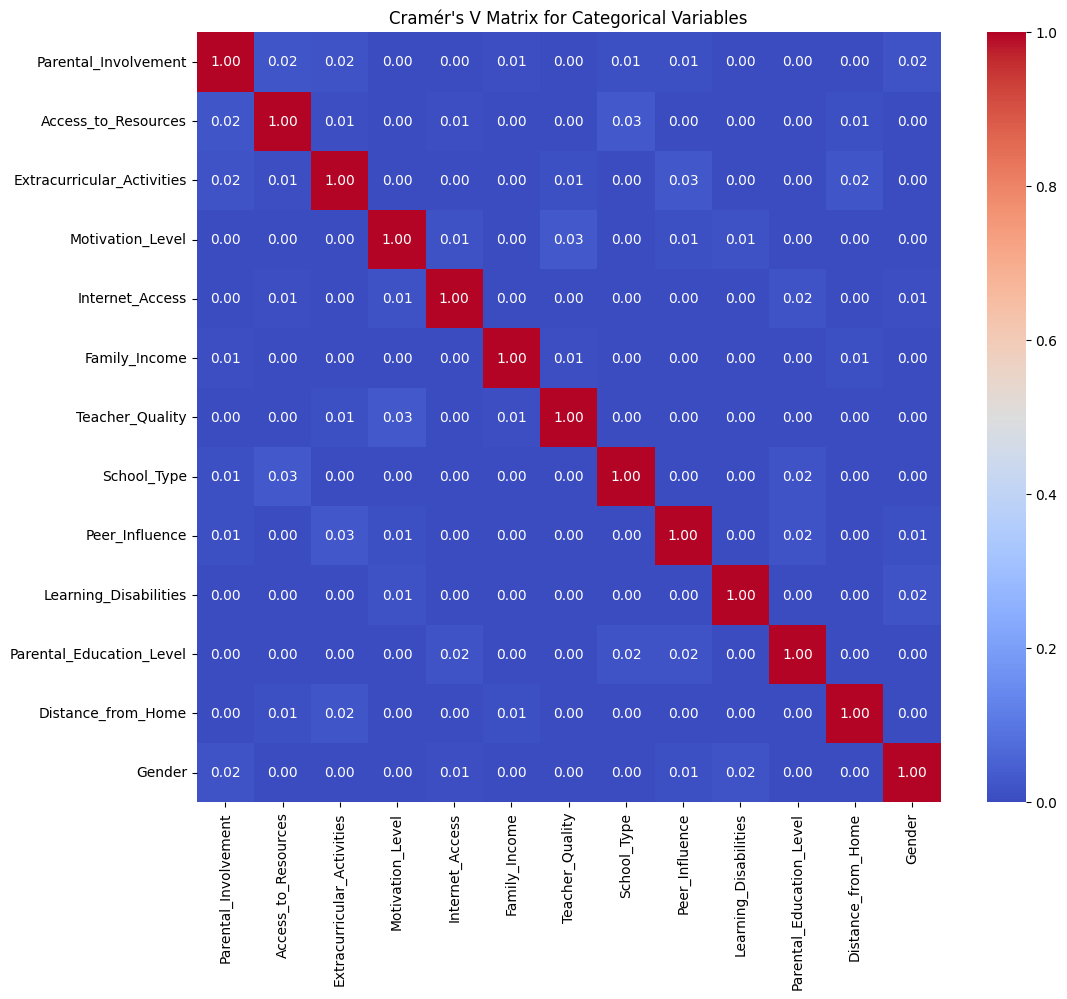

In [14]:
# Create an empty matrix to store Cramer's V values
cramers_v_matrix = pd.DataFrame(index=categoricals.columns, columns=categoricals.columns)

# Iterate through all pairs of categorical columns
for col1 in categoricals.columns:
    for col2 in categoricals.columns:
        cramers_v_matrix.loc[col1, col2] = cramers_v(categoricals[col1], categoricals[col2])

# Convert the Cramér's V matrix to numeric type
cramers_v_matrix = cramers_v_matrix.apply(pd.to_numeric)

# Create the heatmap
plt.figure(figsize=(12, 10))
sns.heatmap(cramers_v_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Cramér\'s V Matrix for Categorical Variables')
plt.show()

### **Data Preparation**

In [15]:
X = data.drop(columns= 'Exam_Score', axis=1)
y = data['Exam_Score']

In [16]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [17]:
X_validate, X_test, y_validate, y_test = train_test_split(X_test, y_test, test_size=0.5, random_state=42)

In [18]:
X_train = pd.get_dummies(X_train, drop_first=True)
X_validate = pd.get_dummies(X_validate, drop_first=True)
X_test = pd.get_dummies(X_test, drop_first=True)

### **Modeling**

In [19]:
#Prints Results of Regression Metrics
def regression_results(y_true, y_pred):

    # Regression metrics
    explained_variance=metrics.explained_variance_score(y_true, y_pred)
    mean_absolute_error=metrics.mean_absolute_error(y_true, y_pred)
    mse=metrics.mean_squared_error(y_true, y_pred)
    mean_squared_log_error=metrics.mean_squared_log_error(y_true, y_pred)
    median_absolute_error=metrics.median_absolute_error(y_true, y_pred)
    r2=metrics.r2_score(y_true, y_pred)

    print('explained_variance: ', round(explained_variance,4))
    print('mean_squared_log_error: ', round(mean_squared_log_error,4))
    print('r2: ', round(r2,4))
    print('MAE: ', round(mean_absolute_error,4))
    print('MSE: ', round(mse,4))
    print('RMSE: ', round(np.sqrt(mse),4))

Function Source: [Stack Overflow](https://stackoverflow.com/questions/26319259/how-to-get-a-regression-summary-in-scikit-learn-like-r-does)

In [20]:
slr = LinearRegression()
slr.fit(X_train[['Attendance']], y_train)
y_pred = slr.predict(X_validate[['Attendance']])
slr_results =regression_results(y_validate, y_pred)
print(slr_results)

explained_variance:  0.3584
mean_squared_log_error:  0.0019
r2:  0.3569
MAE:  2.0728
MSE:  9.4844
RMSE:  3.0797
None


In [21]:
mlr = LinearRegression()
mlr.fit(X_train, y_train)
y_pred = mlr.predict(X_validate)
mlr_results = regression_results(y_validate, y_pred)

explained_variance:  0.7321
mean_squared_log_error:  0.0007
r2:  0.732
MAE:  0.4778
MSE:  3.9528
RMSE:  1.9882


In [22]:
random_forest = RandomForestRegressor()
random_forest.fit(X_train, y_train)
y_pred_rf = random_forest.predict(X_validate)
rf_results = regression_results(y_validate, y_pred_rf)


explained_variance:  0.6229
mean_squared_log_error:  0.001
r2:  0.6211
MAE:  1.1856
MSE:  5.5879
RMSE:  2.3639


In [23]:
knn = KNeighborsRegressor()
knn.fit(X_train, y_train)
y_pred = knn.predict(X_validate)
knn_results = regression_results(y_validate, y_pred)

explained_variance:  0.5147
mean_squared_log_error:  0.0014
r2:  0.5123
MAE:  1.5357
MSE:  7.1917
RMSE:  2.6817


In [24]:
ransac = RANSACRegressor()
ransac.fit(X_train, y_train)
y_pred = ransac.predict(X_validate)
ransac_results = regression_results(y_validate, y_pred)


explained_variance:  0.7344
mean_squared_log_error:  0.0007
r2:  0.733
MAE:  0.4191
MSE:  3.937
RMSE:  1.9842


In [25]:
svr = SVR()
svr.fit(X_train, y_train)
y_pred = svr.predict(X_validate)
svr_results = regression_results(y_validate, y_pred)


explained_variance:  0.5997
mean_squared_log_error:  0.0011
r2:  0.5993
MAE:  1.2956
MSE:  5.9094
RMSE:  2.4309


In [26]:
best_model = ransac

In [37]:
best_model_adj_params = RANSACRegressor(min_samples=200, max_trials=200)
best_model_adj_params.fit(X_train, y_train)
y_pred = best_model_adj_params.predict(X_validate)
best_model_adj_params_results = regression_results(y_validate, y_pred)

explained_variance:  0.7344
mean_squared_log_error:  0.0007
r2:  0.733
MAE:  0.4193
MSE:  3.9373
RMSE:  1.9843


In [40]:
param_grid = {
    'min_samples': [None, 30, 100],
    'max_trials': [100, 1000],
    'loss': ['absolute_error', 'squared_error']
}

grid_search = GridSearchCV(RANSACRegressor(), param_grid, cv=5)
grid_search.fit(X_validate, y_validate)

GridSearchCV(cv=5, estimator=RANSACRegressor(),
             param_grid={'loss': ['absolute_error', 'squared_error'],
                         'max_trials': [100, 1000],
                         'min_samples': [None, 30, 100]})

In [67]:
grid_search.best_params_

{'loss': 'absolute_error', 'max_trials': 1000, 'min_samples': None}

In [69]:
best_model_adj_params = RANSACRegressor(min_samples = None, max_trials=1000, loss='absolute_error' )
best_model_adj_params.fit(X_train, y_train)
y_pred_best = best_model_adj_params.predict(X_validate)
best_model_adj_params_results = regression_results(y_validate, y_pred)

explained_variance:  0.7354
mean_squared_log_error:  0.0007
r2:  0.7338
MAE:  0.4099
MSE:  3.9263
RMSE:  1.9815


In [65]:
scalar = StandardScaler()
X_train_scaled = scalar.fit_transform(X_train)
X_validate_scaled = scalar.transform(X_validate)

In [70]:
best_model_scaled = RANSACRegressor(min_samples = None, max_trials=1000, loss='absolute_error' )
best_model_scaled.fit(X_train_scaled, y_train)
y_pred_scaled = best_model_scaled.predict(X_validate_scaled)
best_model_scaled_results = regression_results(y_validate, y_pred_scaled)

explained_variance:  0.7341
mean_squared_log_error:  0.0007
r2:  0.7327
MAE:  0.4198
MSE:  3.9416
RMSE:  1.9853


In [71]:
final_model = best_model_adj_params
final_model.fit(X_train, y_train)
y_pred_final = final_model.predict(X_test)
final_model_results = regression_results(y_test, y_pred_final)

explained_variance:  0.7307
mean_squared_log_error:  0.0007
r2:  0.7291
MAE:  0.4481
MSE:  4.3798
RMSE:  2.0928


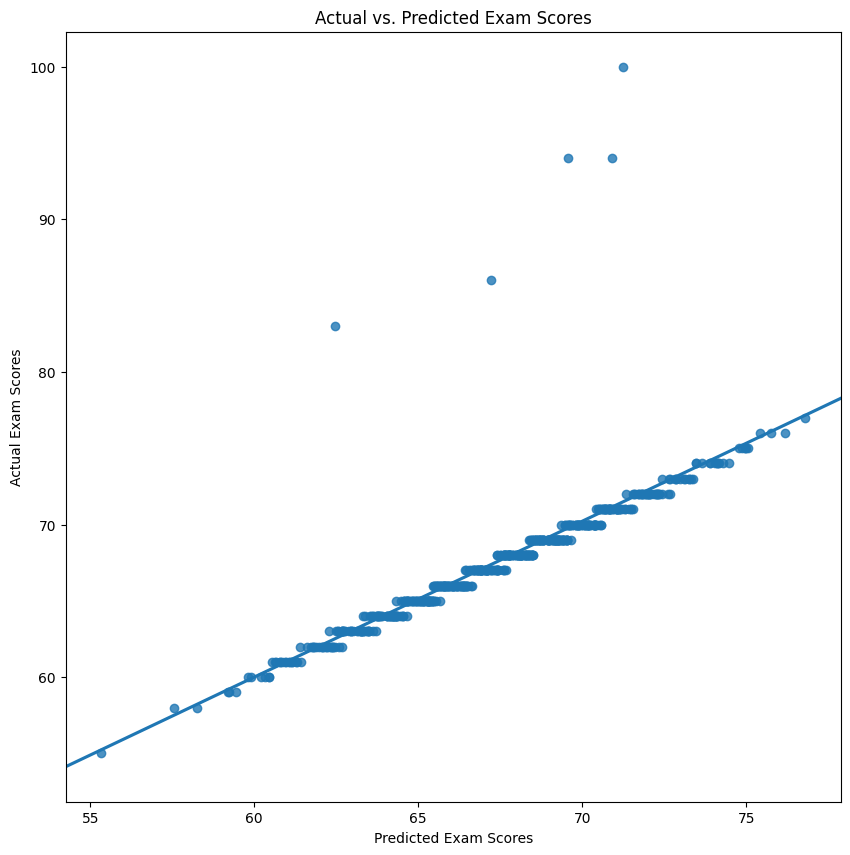

In [72]:
fig, ax = plt.subplots(figsize=(10, 10))

sns.regplot(y=y_test, x=y_pred_final, ci=None, truncate=False, ax=ax)
ax.set_xlabel('Predicted Exam Scores')
ax.set_ylabel('Actual Exam Scores')
ax.set_title('Actual vs. Predicted Exam Scores')
plt.show()


Text(0, 0.5, 'Residuals')

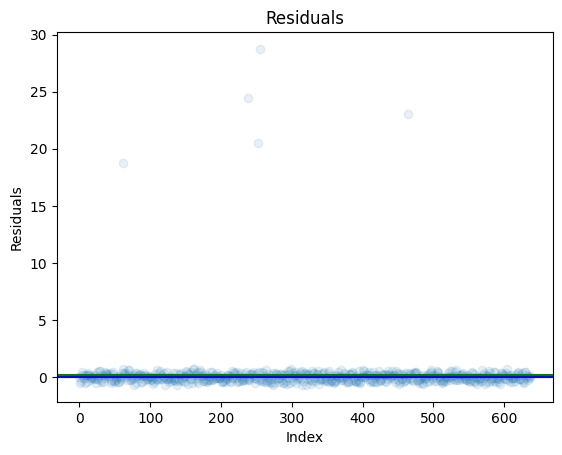

In [73]:
resid = (y_test - y_pred_final)

fig, ax = plt.subplots()
ax.set_title('Residuals')
ax.scatter(x=range(y_pred_final.shape[0]), y = resid, alpha=.1);

ax.axhline(y=0, color='r', linestyle='-')
ax.axhline(y=np.mean(resid), color='g', linestyle='-')
ax.axhline(y=-np.median(resid), color='b', linestyle='-')

ax.set_xlabel('Index')
ax.set_ylabel('Residuals')

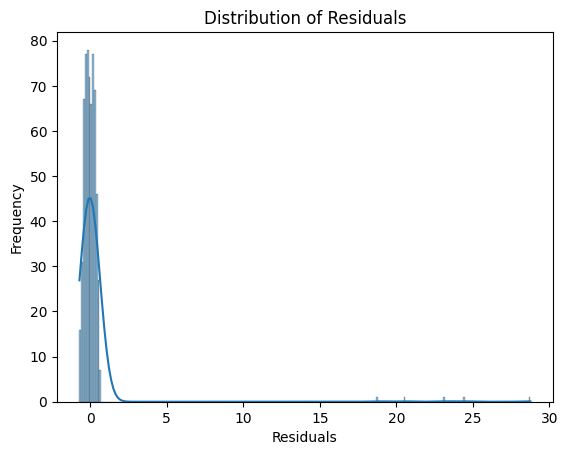

In [75]:
fig, ax = plt.subplots()
sns.histplot(resid, ax=ax, kde=True)
ax.set_title('Distribution of Residuals')
ax.set_xlabel('Residuals')
ax.set_ylabel('Frequency')
plt.show()